#WORKS WITHOUT CUSTOM DATASET

In [ ]:
!pip install torch
!pip install torch_geometric
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=5b38480893d0d524c1dc6fa38713829ec7778441b4e8ea0187cd8e9587f04e0f
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 39.9 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

In [ ]:
!pip install snap-stanford

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 26.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import snap
import pandas as pd
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.data
from dgl.nn import SAGEConv
import dgl.function as fn


graph_path = "/content/drive/MyDrive/ICPC/RedditHyperlinks.tsv"
G5 = snap.LoadEdgeList(snap.TNGraph,graph_path , 0, 1)




DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
df = pd.read_csv(graph_path, sep='\t')


In [ ]:
len(list(set(df["SOURCE_SUBREDDIT"])) + list(set(df["TARGET_SUBREDDIT"]))), len(set(df["SOURCE_SUBREDDIT"])), len(set(df["TARGET_SUBREDDIT"]))

(4488, 2448, 2040)

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch

In [ ]:
#@title Default title text
import pickle
from tqdm import tqdm
uniq_sreddits = list(set(df["SOURCE_SUBREDDIT"])) + list(set(df["TARGET_SUBREDDIT"]))
subreddit_stats = {i : {} for i, x in enumerate(uniq_sreddits) }
edge_indices = []

def gather_node_edge_statistics(df):
  for i, row in tqdm(df.iterrows()):
    SOURCE_SUBREDDIT = uniq_sreddits.index(row[0])
    TARGET_SUBREDDIT = uniq_sreddits.index(row[1])
    edge_indices.append([SOURCE_SUBREDDIT, TARGET_SUBREDDIT])
    # POST_ID          = row[2]
    # TIMESTAMP        = row[3]
    POST_LABEL       = row[4]
    POST_PROPERTIES  = row[5].split(",")

    # we are primarily interested in these averages:
    #8. Number of words
    #43. LIWC_Swear
    #19. Positive sentiment calculated by VADER
    #20. Negative sentiment calculated by VADER
    #21. Compound sentiment calculated by VADER
    #82. LIWC_Death
    #11. Average word length
    # assert len(POST_PROPERTIES) == 86
    if(len(POST_PROPERTIES) != 86):
      print(f"{len(POST_PROPERTIES)=}")
    else:
      nwords = float(POST_PROPERTIES[8-1])
      swear_sentiment = float(POST_PROPERTIES[43 -1])
      positivity = float(POST_PROPERTIES[19 -1])
      negativity = float(POST_PROPERTIES[20 -1])
      compound = float(POST_PROPERTIES[21 -1])
      avg_word_length = float(POST_PROPERTIES[11 - 1])
      # print(f"{POST_PROPERTIES=}")

      # print(f"{SOURCE_SUBREDDIT=}")
      # print(f"{TARGET_SUBREDDIT=}")
      # print(f"{POST_PROPERTIES[8-1]=}")
      # print(f"{type(subreddit_stats[SOURCE_SUBREDDIT])=}")
      # print(f"{type(subreddit_stats[SOURCE_SUBREDDIT])=}")
      if(subreddit_stats[SOURCE_SUBREDDIT] == {}):
        subreddit_stats[SOURCE_SUBREDDIT] = {
            "avg_words" : [nwords],
            "avg_swear_sentiment" : [swear_sentiment],
            "avg_positivity" : [positivity],
            "avg_negativity" : [negativity],
            "avg_compound" : [compound],
            "avg_word_length" : [avg_word_length],
            "sent_posts" : 1,
            "received_posts" : 0
        }
      else: 
        subreddit_stats[SOURCE_SUBREDDIT]["avg_words"].append(nwords)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_swear_sentiment"].append(swear_sentiment)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_positivity"].append(positivity)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_negativity"].append(negativity)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_compound"].append(compound)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_word_length"].append(avg_word_length)
        subreddit_stats[SOURCE_SUBREDDIT]["sent_posts"]+=1

      if(subreddit_stats[TARGET_SUBREDDIT] == {}):
        subreddit_stats[TARGET_SUBREDDIT] = {
          "avg_words" : [0],
          "avg_swear_sentiment" : [0],
          "avg_positivity" : [0],
          "avg_negativity" : [0],
          "avg_compound" : [0],
          "avg_word_length" : [0],
          "sent_posts" : 0,
          "received_posts" : 1
      }
      else:
        subreddit_stats[TARGET_SUBREDDIT]["received_posts"]+=1

    

# node_stats = []
# get node statistics
gather_node_edge_statistics(df)
edge_indices = torch.tensor(edge_indices)

7798it [00:02, 3846.78it/s]


len(POST_PROPERTIES)=33


In [ ]:
edge_indices.max()

tensor(4486)

In [ ]:
import torch

In [ ]:
#@title Default title text
import numpy as np
for i in subreddit_stats.keys():
  if(subreddit_stats[i] != {}):
    # print(f"{subreddit_stats[i]=}")
    # print(f"{type(subreddit_stats[i]['avg_words'])=}")
    # print(f"{subreddit_stats[i]['avg_words']=}")
    subreddit_stats[i]["avg_words"] = np.average(subreddit_stats[i]["avg_words"])
    subreddit_stats[i]["avg_swear_sentiment"] = np.average(subreddit_stats[i]["avg_swear_sentiment"])
    subreddit_stats[i]["avg_positivity"] = np.average(subreddit_stats[i]["avg_positivity"])
    subreddit_stats[i]["avg_negativity"] = np.average(subreddit_stats[i]["avg_negativity"])
    subreddit_stats[i]["avg_compound"] = np.average(subreddit_stats[i]["avg_compound"])
    subreddit_stats[i]["avg_word_length"] = np.average(subreddit_stats[i]["avg_word_length"])


with open("/content/drive/MyDrive/ICPC/subreddit_stats.pkl", "wb")  as f:
  pickle.dump(subreddit_stats, f)

In [ ]:
#@title Default title text
node_stats_list = []
def stats_dict_2_tensor(subreddit_stats):
  _node_stats_list = []
  for i in subreddit_stats.keys():
    _node_stat_list = []
    # print(f"{subreddit_stats[i]=}")
    if(subreddit_stats[i] != {}):
      _node_stat_list.append(subreddit_stats[i]['avg_words'])
      _node_stat_list.append(subreddit_stats[i]['avg_swear_sentiment'])
      _node_stat_list.append(subreddit_stats[i]['avg_positivity'])
      _node_stat_list.append(subreddit_stats[i]['avg_negativity'])
      _node_stat_list.append(subreddit_stats[i]['avg_compound'])
      _node_stat_list.append(subreddit_stats[i]['avg_word_length'])
      _node_stat_list.append(subreddit_stats[i]['sent_posts'])
      _node_stat_list.append(subreddit_stats[i]['received_posts'])
      _node_stats_list.append(_node_stat_list)
  return torch.tensor(_node_stats_list)
node_stats_list = stats_dict_2_tensor(subreddit_stats)

In [ ]:
edge_indices, node_stats_list.shape

(tensor([[2228,  700],
         [ 578, 2238],
         [ 946, 3101],
         ...,
         [ 533, 2239],
         [ 478, 1473],
         [ 367, 2900]]),
 torch.Size([3501, 8]))

In [ ]:
# get rid of entries in the edge_index that reference nodes beyond the nodes in stats_list
pruned_edge_indices = [ x for x in edge_indices if x[0] < node_stats_list.shape[0] and x[1] < node_stats_list.shape[0]  ]
pruned_edge_indices = torch.stack(pruned_edge_indices)
pruned_edge_indices.shape, pruned_edge_indices.max()
edge_indices = pruned_edge_indices

In [ ]:
# 2,3,4,6,7
# correspond to positivity, negativity, compound (negativity and positivity combined), sent, and received respectively
most_negative_node = np.argmin(node_stats_list[:, 4])
most_positive_node = np.argmax(node_stats_list[:, 4])
most_active_node = np.argmax(node_stats_list[:, 6])
most_sweary_node = np.argmax(node_stats_list[: , 1])

# subreddit_stats[most_negative_node],subreddit_stats[most_positive_node], subreddit_stats[most_active_node], subreddit_stats[most_sweary_node]


In [ ]:
from torch_geometric.datasets import Planetoid
# Load data
dataset = Planetoid(root='./data/cora', name='cora')
data = dataset[0]
data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
data.num_node_features, dataset.num_classes

(1433, 7)

In [ ]:

import random 

def gen_train_mask( num_nodes : int, n : int) -> torch.tensor:
  rand_indices = [True] * num_nodes
  for i in range(n):
    num = random.randint(0, num_nodes - 1)
    rand_indices[num] = False
  return rand_indices
  
gen_train_mask(15, 2)

[True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True]

In [ ]:
from torch_geometric.data import Data

train_mask = gen_train_mask(node_stats_list.shape[0], round(0.3 * node_stats_list.shape[0]))
# train_mask = gen_train_mask(edge_indices.shape[0], round(0.60 * edge_indices.shape[0]))
train_mask = torch.tensor(train_mask)
x = torch.tensor(node_stats_list)
x = x.float()
edge_indices = edge_indices.int()
print(f"{type(x)=}")
print(f"{edge_indices.shape=}")
dataset = Data(x =x , edge_index = edge_indices.T, train_mask =train_mask  )


type(x)=<class 'torch.Tensor'>
edge_indices.shape=torch.Size([6591, 2])


<ipython-input-21-ab3782da0f76>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(node_stats_list)


In [ ]:
dataset.x.shape, dataset.edge_index.shape

(torch.Size([3501, 8]), torch.Size([2, 6591]))

In [ ]:
dataset.x[dataset.train_mask][0],  dataset.x[~dataset.train_mask][0]

num_nodes = dataset.x.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:500] = 1

# Use the train_mask to get the subset of nodes and edges
sub_data = dataset.x[train_mask]
sub_data.shape

torch.Size([500, 8])

In [ ]:
dataset.edge_index[:, :].max()

tensor(3498, dtype=torch.int32)

In [ ]:
# NEED TO MAKE IT SO THAT MAX ENTRY IN DATASET.X IS < len(uniq_sreddits)!!!!!
dataset.edge_index.shape, dataset.x.shape, len(uniq_sreddits)

(torch.Size([2, 6591]), torch.Size([3501, 8]), 4488)

In [ ]:
dataset.num_features

8

In [ ]:
num_train_nodes = round(dataset.edge_index.shape[1] * 0.8)
train_mask = torch.zeros(dataset.edge_index.shape[1], dtype=torch.bool)
train_mask[:num_train_nodes] = True
dataset = Data(x =x , edge_index = edge_indices.T, train_mask =train_mask  )

In [ ]:
from torch_geometric.utils import negative_sampling

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [ ]:
node_stats_list.shape, edge_indices.shape, edge_indices

(torch.Size([3501, 8]),
 torch.Size([6591, 2]),
 tensor([[2228,  700],
         [ 578, 2238],
         [ 946, 3101],
         ...,
         [ 533, 2239],
         [ 478, 1473],
         [ 367, 2900]], dtype=torch.int32))

In [ ]:
# Set up the training and testing data
edge_index = edge_indices.T
total_indices = edge_indices.shape[0]
total_indices

alpha = 0.8
train_size = round((alpha) * total_indices)
test_size =  round( (1 - alpha) * total_indices )

In [ ]:
total_indices, train_size, test_size, edge_index.shape

(6591, 5273, 1318, torch.Size([2, 6591]))

In [ ]:



# subsample the training and test based off the positive edge_indices instead of the negative edge indices

neg_edge_index = negative_sampling(
        edge_index=edge_index,
        num_nodes=node_stats_list.shape[0],
        num_neg_samples=edge_index.shape[1]
    )


train_pos_edge_index = edge_index[:, :train_size] 
train_neg_edge_index = neg_edge_index[:, :train_size]


test_pos_edge_index = edge_index[:, train_size:]
test_neg_edge_index = neg_edge_index[:, train_size:]



In [ ]:
train_neg_edge_index.shape, train_pos_edge_index.shape, test_pos_edge_index.shape, test_neg_edge_index.shape

(torch.Size([2, 5273]),
 torch.Size([2, 5273]),
 torch.Size([2, 1318]),
 torch.Size([2, 1318]))

In [ ]:
train_pos_edge_index,train_neg_edge_index 

(tensor([[2228,  578,  946,  ...,  955,  284, 1574],
         [ 700, 2238, 3101,  ...,  137, 1029,  924]], dtype=torch.int32),
 tensor([[1881,  391, 2420,  ...,   73, 2651,  205],
         [ 679, 1464, 3291,  ..., 2887,  527, 3158]]))

In [ ]:
import torch.nn as nn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
node_stats_list = torch.tensor(node_stats_list).float().to(device)

<ipython-input-38-8cb65b2050cc>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_stats_list = torch.tensor(node_stats_list).float().to(device)


In [ ]:
node_stats_list = torch.nn.functional.normalize(node_stats_list, p=2.0, dim = 1)

In [ ]:
torch.norm(node_stats_list[0]), node_stats_list[0]

(tensor(1.0000),
 tensor([9.9930e-01, 4.5336e-06, 1.3124e-04, 1.6984e-04, 4.0229e-05, 9.0565e-03,
         5.1466e-03, 3.6026e-02]))

In [ ]:
import tqdm
from tqdm import tqdm

In [ ]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch_geometric.datasets as datasets

In [ ]:
# dataset = Planetoid(root=data_dir, name='Cora')
# data = dataset[0]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])
dataset = Planetoid(root="./data/", name='Cora', transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]

Processing...
Done!


In [ ]:
train_data
train_pos_edge_index = edge_index[:, :train_size] 
train_neg_edge_index = neg_edge_index[:, :train_size]


test_pos_edge_index = edge_index[:, train_size:]
test_neg_edge_index = neg_edge_index[:, train_size:]

# train_data = Data(x = node_stats_list, edge_index = train_pos_edge_index

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

def train():
  model.train()
  optimizer.zero_grad()
  z = model.encode(train_data.x, train_data.edge_index)

  # We perform a new round of negative sampling for every training epoch:
  neg_edge_index = negative_sampling(
      edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
      num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

  edge_label_index = torch.cat(
      [train_data.edge_label_index, neg_edge_index],
      dim=-1,
  )
  edge_label = torch.cat([
      train_data.edge_label,
      train_data.edge_label.new_zeros(neg_edge_index.size(1))
  ], dim=0)

  out = model.decode(z, edge_label_index).view(-1)
  loss = criterion(out, edge_label)
  loss.backward()
  optimizer.step()
  return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [ ]:
epochs = 101

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

best_val_auc = final_test_auc = 0
losses = []
test_vals = []
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    val_auc = test(val_data)
    test_vals.append(val_auc)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)



Epoch: 001, Loss: 0.6930, Val: 0.6552, Test: 0.6811
Epoch: 002, Loss: 0.6812, Val: 0.6523, Test: 0.6795
Epoch: 003, Loss: 0.7148, Val: 0.6562, Test: 0.6895
Epoch: 004, Loss: 0.6771, Val: 0.6642, Test: 0.7124
Epoch: 005, Loss: 0.6852, Val: 0.6866, Test: 0.7389
Epoch: 006, Loss: 0.6893, Val: 0.7116, Test: 0.7625
Epoch: 007, Loss: 0.6907, Val: 0.7030, Test: 0.7367
Epoch: 008, Loss: 0.6908, Val: 0.6804, Test: 0.7018
Epoch: 009, Loss: 0.6897, Val: 0.6698, Test: 0.6882
Epoch: 010, Loss: 0.6872, Val: 0.6653, Test: 0.6845
Epoch: 011, Loss: 0.6830, Val: 0.6617, Test: 0.6845
Epoch: 012, Loss: 0.6782, Val: 0.6603, Test: 0.6867
Epoch: 013, Loss: 0.6791, Val: 0.6606, Test: 0.6899
Epoch: 014, Loss: 0.6771, Val: 0.6596, Test: 0.6929
Epoch: 015, Loss: 0.6716, Val: 0.6613, Test: 0.6949
Epoch: 016, Loss: 0.6670, Val: 0.6634, Test: 0.6943
Epoch: 017, Loss: 0.6634, Val: 0.6620, Test: 0.6916
Epoch: 018, Loss: 0.6575, Val: 0.6591, Test: 0.6872
Epoch: 019, Loss: 0.6495, Val: 0.6576, Test: 0.6850
Epoch: 020, 

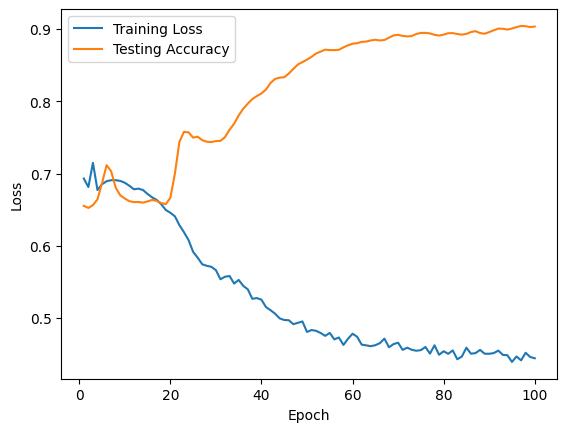

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
  epochs_plot = np.arange(1, epochs, 1)
  plt.plot(epochs_plot.tolist(), losses, label="Training Loss")
  plt.plot(epochs_plot.tolist(), test_vals, label="Testing Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

191808

In [ ]:
# train_graph = torch.load('train.pt')
# val_graph = torch.load('val.pt')


optim_wd = 0.01
epochs = 50
hidden_dim = 200
dropout = 0.1
num_layers = 2
lr = 0.1
node_emb_dim = 1
batch_size = 10


# train_graph = train_graph.to(device)
# val_graph = val_graph.to(device)

# model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(node_stats_list.shape[1], hidden_dim, 1, num_layers + 1, dropout).to(device)
# pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )
pred = link_predictor(node_stats_list[0], node_stats_list[100])

optimizer = torch.optim.Adam(
    link_predictor.parameters(),
    lr=lr, weight_decay=optim_wd
)

train_losses = []

for epoch in tqdm(range(epochs)):
  train_loss = train(
	link_predictor, 
	batch_size, 
	optimizer
  )
  print(f"{train_loss=}")
  train_losses.append(train_loss)

train_loss 




<ipython-input-131-9961cd76c00b>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
<ipython-input-131-9961cd76c00b>:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
  2%|▏         | 1/50 [00:01<01:32,  1.88s/it]

train_loss=1.3526895154397


  4%|▍         | 2/50 [00:03<01:33,  1.95s/it]

train_loss=1.3047347934089573


  6%|▌         | 3/50 [00:05<01:17,  1.65s/it]

train_loss=1.2941599496313043


  8%|▊         | 4/50 [00:06<01:07,  1.46s/it]

train_loss=1.3008595271230203


 10%|█         | 5/50 [00:07<01:03,  1.42s/it]

train_loss=1.308869653226786


 12%|█▏        | 6/50 [00:09<01:00,  1.39s/it]

train_loss=1.2950366433983145


 14%|█▍        | 7/50 [00:10<00:57,  1.33s/it]

train_loss=1.377965286891893


 16%|█▌        | 8/50 [00:11<00:55,  1.32s/it]

train_loss=1.300130299964927


 18%|█▊        | 9/50 [00:12<00:53,  1.31s/it]

train_loss=1.2910549967445462


 20%|██        | 10/50 [00:14<00:57,  1.43s/it]

train_loss=1.2951000098095897


 22%|██▏       | 11/50 [00:20<01:44,  2.68s/it]

train_loss=1.3118715870794642


 24%|██▍       | 12/50 [00:22<01:38,  2.59s/it]

train_loss=1.306962281695664


 26%|██▌       | 13/50 [00:24<01:28,  2.38s/it]

train_loss=1.2957531699342617


 28%|██▊       | 14/50 [00:25<01:13,  2.05s/it]

train_loss=1.3065952840458932


 30%|███       | 15/50 [00:26<01:04,  1.83s/it]

train_loss=1.3238326169579187


 32%|███▏      | 16/50 [00:28<00:56,  1.65s/it]

train_loss=1.2923953975029434


 34%|███▍      | 17/50 [00:29<00:51,  1.57s/it]

train_loss=1.298761048947522


 36%|███▌      | 18/50 [00:31<00:50,  1.57s/it]

train_loss=1.3455625395056825


 38%|███▊      | 19/50 [00:32<00:49,  1.61s/it]

train_loss=1.298280746895374


 40%|████      | 20/50 [00:34<00:49,  1.65s/it]

train_loss=1.2931981889897792


 42%|████▏     | 21/50 [00:36<00:48,  1.66s/it]

train_loss=1.29624980101254


 44%|████▍     | 22/50 [00:37<00:42,  1.53s/it]

train_loss=1.3023741055409421


 46%|████▌     | 23/50 [00:38<00:39,  1.46s/it]

train_loss=1.301714684512164


 48%|████▊     | 24/50 [00:40<00:36,  1.41s/it]

train_loss=1.2942041513082143


 50%|█████     | 25/50 [00:41<00:34,  1.37s/it]

train_loss=1.3330781347042806


 52%|█████▏    | 26/50 [00:42<00:32,  1.37s/it]

train_loss=1.292212407331209


 54%|█████▍    | 27/50 [00:43<00:30,  1.32s/it]

train_loss=1.311496911476938


 56%|█████▌    | 28/50 [00:45<00:28,  1.32s/it]

train_loss=1.2990929609790272


 58%|█████▊    | 29/50 [00:46<00:28,  1.36s/it]

train_loss=1.3037900486277798


 60%|██████    | 30/50 [00:48<00:30,  1.50s/it]

train_loss=1.3284027994139314


 62%|██████▏   | 31/50 [00:50<00:29,  1.57s/it]

train_loss=1.2915312477520533


 64%|██████▍   | 32/50 [00:51<00:28,  1.58s/it]

train_loss=1.2959358197381599


 66%|██████▌   | 33/50 [00:53<00:25,  1.51s/it]

train_loss=1.3012605594852256


 68%|██████▊   | 34/50 [00:54<00:22,  1.44s/it]

train_loss=1.3105112028858377


 70%|███████   | 35/50 [00:55<00:20,  1.38s/it]

train_loss=1.302429101757101


 72%|███████▏  | 36/50 [00:56<00:18,  1.34s/it]

train_loss=1.2944911902475542


 74%|███████▍  | 37/50 [00:58<00:16,  1.29s/it]

train_loss=1.2986919274661533


 76%|███████▌  | 38/50 [00:59<00:15,  1.26s/it]

train_loss=1.328825522803892


 78%|███████▊  | 39/50 [01:00<00:13,  1.26s/it]

train_loss=1.3013065708189857


 80%|████████  | 40/50 [01:02<00:13,  1.40s/it]

train_loss=1.291556608838004


 82%|████████▏ | 41/50 [01:04<00:13,  1.55s/it]

train_loss=1.2987661544650677


 84%|████████▍ | 42/50 [01:06<00:13,  1.64s/it]

train_loss=1.2983771569480307


 86%|████████▌ | 43/50 [01:07<00:11,  1.63s/it]

train_loss=1.3195132641948788


 88%|████████▊ | 44/50 [01:08<00:09,  1.51s/it]

train_loss=1.292911826988905


 90%|█████████ | 45/50 [01:10<00:07,  1.44s/it]

train_loss=1.3148044580198164


 92%|█████████▏| 46/50 [01:11<00:05,  1.39s/it]

train_loss=1.310422154582145


 94%|█████████▍| 47/50 [01:12<00:04,  1.36s/it]

train_loss=1.288130056328755


 96%|█████████▌| 48/50 [01:13<00:02,  1.32s/it]

train_loss=1.3227597692528286


 98%|█████████▊| 49/50 [01:15<00:01,  1.30s/it]

train_loss=1.3064424127455383


100%|██████████| 50/50 [01:16<00:00,  1.53s/it]

train_loss=1.2886654533244468


1.2886654533244468

In [ ]:
test_pos_edge_index.shape

torch.Size([2, 1295])

In [ ]:
test_pos_edge_index.shape, test_pos_edge_index[0, :]

(torch.Size([2, 1295]),
 tensor([1763,  521, 1486,  ..., 2157, 1760, 1101], dtype=torch.int32))

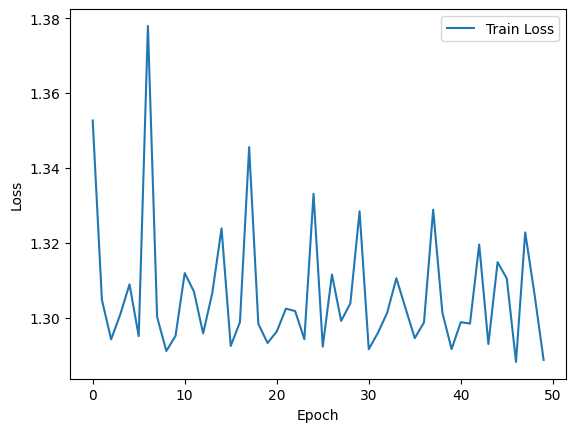

In [ ]:
import matplotlib.pyplot as plt

epochs_plot = np.arange(0, epochs, 1)
plt.plot(epochs_plot, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
pos_preds = []
neg_preds = []

for iedge in range(0, test_pos_edge_index.shape[1], 1):
  pos_edge = test_pos_edge_index[:, iedge:iedge+1]  # (2, B)
  pos_pred = link_predictor(node_stats_list[pos_edge[0]], node_stats_list[pos_edge[1]])  # (B, )
  pos_preds.append(pos_pred)

  neg_edge = test_neg_edge_index[:, iedge:iedge+1]  # (2, B)
  neg_pred = link_predictor(node_stats_list[neg_edge[0]], node_stats_list[neg_edge[1]])  # (Ne,)
  neg_preds.append(neg_pred)

NameError: ignored

In [ ]:
pos_preds = []
neg_preds = []

for iedge in range(0, test_pos_edge_index.shape[1], 1):
  pos_edge = test_pos_edge_index[:, iedge:iedge+1]  # (2, B)
  pos_pred = link_predictor(node_stats_list[pos_edge[0]], node_stats_list[pos_edge[1]])  # (B, )
  pos_preds.append(pos_pred)

  neg_edge = test_neg_edge_index[:, iedge:iedge+1]  # (2, B)
  neg_pred = link_predictor(node_stats_list[neg_edge[0]], node_stats_list[neg_edge[1]])  # (Ne,)
  neg_preds.append(neg_pred)

In [ ]:
pos_preds = torch.tensor(pos_preds)
neg_preds = torch.tensor(neg_preds)

true_positives = (pos_preds>0.5).sum() 
false_negatives = (pos_preds<0.5).sum() 

true_negatives= (neg_preds<0.5).sum() 
false_positives = (neg_preds>0.5).sum() 
confusion_matrix = torch.tensor([  [true_positives,false_positives ] ,   [false_negatives, true_negatives]])

<Axes: >

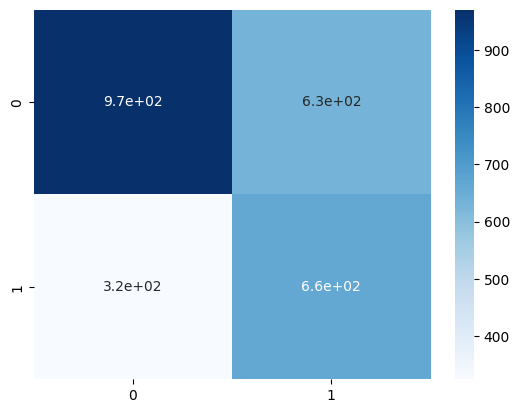

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

In [ ]:
accuracy= (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives )
print(f"{accuracy=}")

accuracy=tensor(0.6313)


<Axes: >

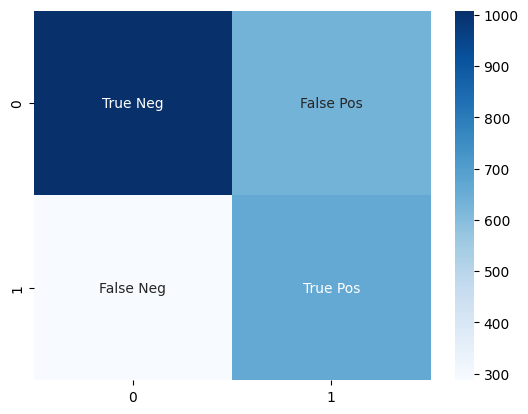

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:

train_loss  

1.2941446313526639

In [ ]:
pred = link_predictor(node_stats_list[0], node_stats_list[00])
pred